In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

Credit Card Balance duplicated rows: 0
Missing values in Credit Card Balance:
 AMT_DRAWINGS_ATM_CURRENT      18.765817
AMT_DRAWINGS_OTHER_CURRENT    18.765817
AMT_DRAWINGS_POS_CURRENT      18.765817
AMT_INST_MIN_REGULARITY        8.190423
AMT_PAYMENT_CURRENT           19.210029
CNT_DRAWINGS_ATM_CURRENT      18.765817
CNT_DRAWINGS_OTHER_CURRENT    18.765817
CNT_DRAWINGS_POS_CURRENT      18.765817
CNT_INSTALMENT_MATURE_CUM      8.190423
dtype: float64


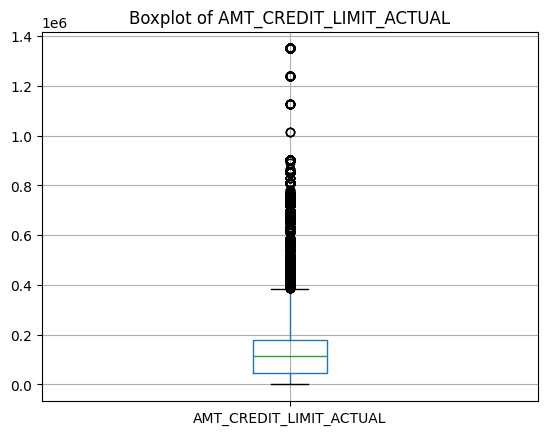

Credit card balance features saved.


In [ ]:
# STEP 1: LOAD DATA
application_train = pd.read_csv('/content/drive/My Drive/group6_Final_DP/data/raw_data/application_train.csv')
credit_card_balance = pd.read_csv('/content/drive/My Drive/group6_Final_DP/data/raw_data/credit_card_balance.csv')

# STEP 2: KIỂM TRA DỮ LIỆU TRÙNG LẶP
print("Credit Card Balance duplicated rows:", credit_card_balance.duplicated().sum())
credit_card_balance = credit_card_balance.drop_duplicates()

# STEP 3: PHÂN TÍCH VÀ XỬ LÝ GIÁ TRỊ THIẾU
missing_ccb = credit_card_balance.isnull().sum() / len(credit_card_balance) * 100
print("Missing values in Credit Card Balance:\n", missing_ccb[missing_ccb > 0])

# Xử lý giá trị thiếu bằng cách điền giá trị trung bình hoặc 0
credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'] = credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'].fillna(credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'].mean())
credit_card_balance['AMT_DRAWINGS_CURRENT'] = credit_card_balance['AMT_DRAWINGS_CURRENT'].fillna(0)
credit_card_balance['CNT_DRAWINGS_CURRENT'] = credit_card_balance['CNT_DRAWINGS_CURRENT'].fillna(0)
credit_card_balance['AMT_INST_MIN_REGULARITY'] = credit_card_balance['AMT_INST_MIN_REGULARITY'].fillna(0)
credit_card_balance = credit_card_balance.fillna(0)

# STEP 4: XỬ LÝ NGOẠI LỆ
# Kiểm tra ngoại lệ
credit_card_balance.boxplot(column=['AMT_CREDIT_LIMIT_ACTUAL'])
plt.title('Boxplot of AMT_CREDIT_LIMIT_ACTUAL')
plt.show()

# Loại bỏ ngoại lệ dựa trên percentile
lower_bound = credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'].quantile(0.01)
upper_bound = credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'].quantile(0.99)
credit_card_balance = credit_card_balance[(credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'] >= lower_bound) &
                                          (credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'] <= upper_bound)]

# STEP 5: TẠO CÁC FEATURE MỚI (FEATURE ENGINEERING)
# Sort values
credit_card_balance = credit_card_balance.sort_values(['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'])

# Count cards
ccb_prev_count = credit_card_balance.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()

# Installments
credit_card_balance['PAY_MONTH'] = credit_card_balance.CNT_INSTALMENT_MATURE_CUM.map(lambda x: 1 if x > 0 else 0)
ccb_temp = credit_card_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['PAY_MONTH'].sum().reset_index()
ccb_avg_inst_card = ccb_temp.groupby('SK_ID_CURR')['PAY_MONTH'].mean()
ccb_total_inst_card = ccb_temp.groupby('SK_ID_CURR')['PAY_MONTH'].sum()

# Limit
ccb_temp = credit_card_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['AMT_CREDIT_LIMIT_ACTUAL'].mean().reset_index()
ccb_avg_limit_card = ccb_temp.groupby('SK_ID_CURR')['AMT_CREDIT_LIMIT_ACTUAL'].mean()
ccb_max_limit_card = credit_card_balance.groupby('SK_ID_CURR')['AMT_CREDIT_LIMIT_ACTUAL'].max()
ccb_total_limit_card = ccb_temp.groupby('SK_ID_CURR')['AMT_CREDIT_LIMIT_ACTUAL'].sum()

# Avg drawing amount
ccb_temp = credit_card_balance.loc[credit_card_balance.CNT_DRAWINGS_CURRENT > 0].groupby(['SK_ID_CURR', 'MONTHS_BALANCE'])[['AMT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_CURRENT']].sum().reset_index()
ccb_temp['avg_drawing_amount'] = (ccb_temp.AMT_DRAWINGS_CURRENT / ccb_temp.CNT_DRAWINGS_CURRENT).fillna(0)
ccb_avg_drawing_amount = ccb_temp.groupby('SK_ID_CURR')['avg_drawing_amount'].mean().fillna(0)

# Count Refused
ccb_count_rej = credit_card_balance.groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].apply(lambda x: (x == 'Refused').sum())

# Current credit card situation
last_month_credit = credit_card_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['MONTHS_BALANCE'].max().reset_index()
last_month_credit = last_month_credit.merge(credit_card_balance, on=['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'])

ccb_cur_total_receivable = last_month_credit.groupby('SK_ID_CURR')['AMT_TOTAL_RECEIVABLE'].sum()
ccb_cur_total_limit = last_month_credit.loc[last_month_credit.NAME_CONTRACT_STATUS == 'Active'].groupby('SK_ID_CURR')['AMT_CREDIT_LIMIT_ACTUAL'].sum()
ccb_cur_total_payment = last_month_credit.groupby('SK_ID_CURR')['AMT_INST_MIN_REGULARITY'].sum()
ccb_cur_total_balance = last_month_credit.groupby('SK_ID_CURR')['AMT_BALANCE'].sum()

# Drawing in 1 year
ccb_temp = credit_card_balance.loc[credit_card_balance.MONTHS_BALANCE >= -12]
ccb_drawing_amount_1y = ccb_temp.groupby('SK_ID_CURR')['AMT_DRAWINGS_CURRENT'].sum()
ccb_drawing_times_1y = ccb_temp.groupby('SK_ID_CURR')['CNT_DRAWINGS_CURRENT'].sum()

# Drawing in 6 months
ccb_temp = credit_card_balance.loc[credit_card_balance.MONTHS_BALANCE >= -6]
ccb_drawing_amount_6m = ccb_temp.groupby('SK_ID_CURR')['AMT_DRAWINGS_CURRENT'].sum()
ccb_drawing_times_6m = ccb_temp.groupby('SK_ID_CURR')['CNT_DRAWINGS_CURRENT'].sum()

# DPD
ccb_temp = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV', 'SK_DPD', 'SK_DPD_DEF']].groupby(['SK_ID_CURR', 'SK_ID_PREV'])[['SK_DPD', 'SK_DPD_DEF']].max().reset_index()
ccb_max_dpd_days = ccb_temp.groupby('SK_ID_CURR')['SK_DPD'].max()
ccb_total_dpd_days = ccb_temp.groupby('SK_ID_CURR')['SK_DPD'].sum()
ccb_max_largedpd_days = ccb_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].max()
ccb_total_largedpd_days = ccb_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].sum()

# STEP 6: LƯU DỮ LIỆU
ccb_feature = pd.DataFrame({
    'ccb_prev_count': ccb_prev_count,
    'ccb_avg_inst_card': ccb_avg_inst_card,
    'ccb_avg_limit_card': ccb_avg_limit_card,
    'ccb_total_inst_card': ccb_total_inst_card,
    'ccb_count_rej': ccb_count_rej,
    'ccb_max_limit_card': ccb_max_limit_card,
    'ccb_total_limit_card': ccb_total_limit_card,
    'ccb_avg_drawing_amount': ccb_avg_drawing_amount,
    'ccb_cur_total_receivable': ccb_cur_total_receivable,
    'ccb_cur_total_limit': ccb_cur_total_limit,
    'ccb_cur_total_payment': ccb_cur_total_payment,
    'ccb_cur_total_balance': ccb_cur_total_balance,
    'ccb_drawing_amount_1y': ccb_drawing_amount_1y,
    'ccb_drawing_times_1y': ccb_drawing_times_1y,
    'ccb_drawing_amount_6m': ccb_drawing_amount_6m,
    'ccb_drawing_times_6m': ccb_drawing_times_6m,
    'ccb_max_dpd_days': ccb_max_dpd_days,
    'ccb_total_dpd_days': ccb_total_dpd_days,
    'ccb_max_largedpd_days': ccb_max_largedpd_days,
    'ccb_total_largedpd_days': ccb_total_largedpd_days
}).reset_index()

ccb_feature.to_csv('/content/drive/My Drive/group6_Final_DP/data/processed_data/ccb_feature.csv', index=False)
print("Credit card balance features saved.")
